# Eurozone CPI, ECB Deposit Facility, Marginal Lending Facility rates, and Market Yield on Government Bonds at 10-Year
This notebook jaxteposes the evolution of Eurozone CPI with ECB Deposit Facility Rate and 10 year Government Bond yields.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1996-01-01')
report_end = date.today()

### Get Consumer Price Index for Eurozone (19 countries), ECB Deposit Facility Rate, and 10 Year Government Bond Yields
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `CP0000EZ19M086NEST` &mdash; Harmonized Index of Consumer Prices: All Items for Euro area (19 countries) (monthly frequency, from 1996)
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency, from 1999)
* `ECBMLFR` &mdash; ECB Marginal Lending Facility Rate for Euro Area (daily frequency, from 1999)
* `IRLTLT01DEM156N` &mdash; Long-Term Government Bond Yields: 10-year Germany (monthly frequency, from 1960)
* `IRLTLT01ITM156N` &mdash; Long-Term Government Bond Yields: 10-year Italy (monthly frequency, from 1960)

In [3]:
fred_cpi_ecbr = web.get_data_fred(['CP0000EZ19M086NEST', 'IRLTLT01DEM156N', 'IRLTLT01ITM156N'], start=report_start, end=report_end)
fred_ecbr = web.get_data_fred(['ECBDFR', 'ECBMLFR'], start=report_start, end=report_end)

# Make frequencies explicit, resample to month srart
fred_cpi_ecbr = fred_cpi_ecbr.asfreq('MS')
fred_ecbr = fred_ecbr.asfreq('D').resample('MS').last()

# Since CP0000EZ19M086NEST is indexed to 2015=100, we need to convert it to annual percentage changes
fred_cpi_ecbr.update(fred_cpi_ecbr.CP0000EZ19M086NEST.pct_change(12)*100)

# Merge and truncate to start of celendar year 1999.
fred_cpi_ecbr = pd.concat([fred_cpi_ecbr, fred_ecbr], axis=1).loc['1999':]

fred_cpi_ecbr = fred_cpi_ecbr[['CP0000EZ19M086NEST', 'ECBDFR', 'ECBMLFR', 'IRLTLT01DEM156N', 'IRLTLT01ITM156N']]

In [4]:
fred_cpi_ecbr.rename(
    columns={'CP0000EZ19M086NEST': 'Annual Eurozone CPI',
             'ECBDFR': 'ECB Deposit Facility Rate', 'ECBMLFR': 'ECB Marginal Lending Facility Rate',
             'IRLTLT01DEM156N': '10y German Government Bond Yield',
             'IRLTLT01ITM156N': '10y Italian Government Bond Yield'},
    inplace=True)
fred_cpi_ecbr

,Annual Eurozone CPI,ECB Deposit Facility Rate,ECB Marginal Lending Facility Rate,10y German Government Bond Yield,10y Italian Government Bond Yield
DATE,,,,,
1999-01-01,0.851414,2.0,4.50,3.702000,3.922330
1999-02-01,0.835616,2.0,4.50,3.849000,4.053790
1999-03-01,1.025992,2.0,4.50,4.037826,4.271240
1999-04-01,1.132642,1.5,3.50,3.850000,4.110220
1999-05-01,0.994144,1.5,3.50,4.012105,4.279190
...,...,...,...,...,...
2022-03-01,7.443913,-0.5,0.25,0.281739,1.853800
2022-04-01,7.438865,-0.5,0.25,0.746316,2.436000
2022-05-01,8.052504,-0.5,0.25,0.952727,2.989800


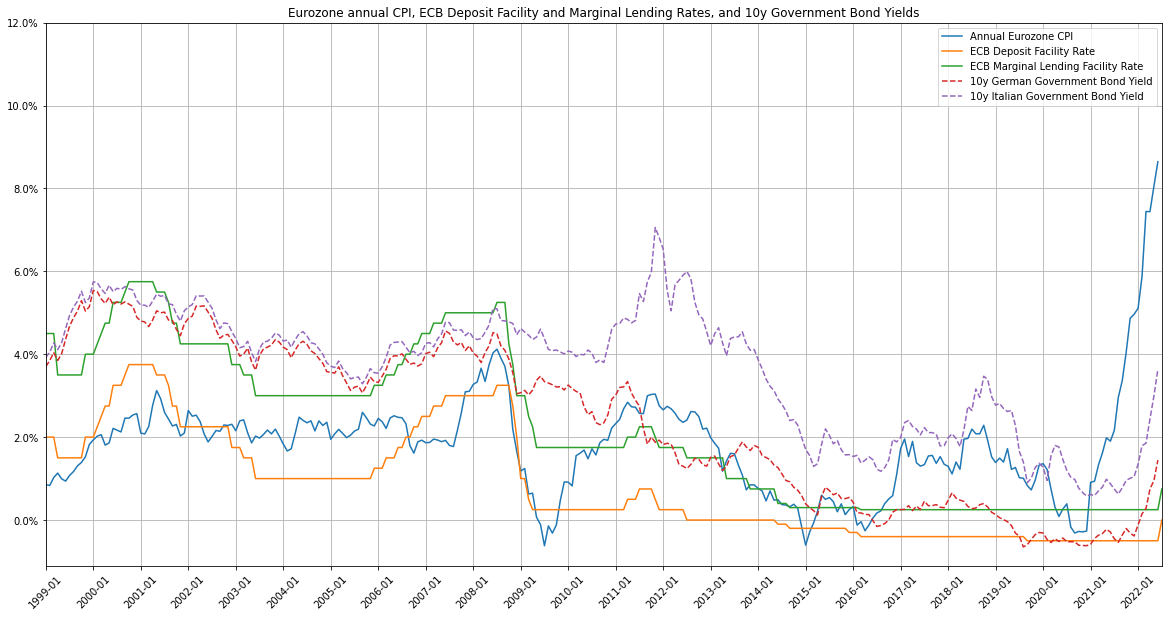

In [5]:
ax = fred_cpi_ecbr.iloc[:,:3].plot(figsize=(20,10), grid=True,
                        title='Eurozone annual CPI, ECB Deposit Facility and Marginal Lending Rates, and 10y Government Bond Yields',
                        xticks=fred_cpi_ecbr.index[::12], xlabel='', rot=45, yticks=np.arange(0, 14, 2))
fred_cpi_ecbr.iloc[:,3:].plot(ax=ax, linestyle='--', grid=True,
                        xticks=fred_cpi_ecbr.index[::12], xlabel='', rot=45, yticks=np.arange(0, 14, 2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), fred_cpi_ecbr.index[::12])))